In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# What We're Building
This notebook contains code for a multilayer classification model utilizing the iris dataset to distinguish linearly separable classes of iris plants. The model architecture is largely described here:
$$\underbrace{\mathbb{R}_4}_{\text{Input layer}}\xrightarrow{}\underbrace{\mathbb{R}_{64}}_{\text{Hidden layer }h_1}\xrightarrow{}\underbrace{\mathbb{R}_{64}}_{\text{Hidden layer }h_2}\xrightarrow{}\underbrace{\mathbb{R}_3}_{\text{Output layer}}$$

<img src="../etc/multi-out-arch.svg" width="1200" height="700" style="display: block; margin: auto;">

## Terminology
> __Fully connected__ means that each node in layer $n$ projects to each node in layer $n+1$. Each connection has its own weight.

## Softmax'ing the Outputs
Applying the sigmoid function $\forall\in\mathbb{R}_3$ would cause us to obtain _isolated_ probabilities, e.g., not a probabilitiy distribution over all predicted classes. Therefore the output vectors don't add up to 1, e.g. $\sum \mathbb{R}_3\ne 1$. For this reason, we pass the raw outputs from $\mathbb{R}_3$ through the _softmax_ function instead.
> The _softmax_ function
$$\sigma_i=\frac{e^{z_i}}{\sum e^z}$$
* With softmax
    $\sum\mathbb{R}_3=1$

Thus, we can summarize the forward phase (from $\mathbb{R}_3$ to finality) as:
$$\mathbb{R}_3\xrightarrow{}\sigma\xrightarrow{}\begin{pmatrix}\hat y_1 \\ \hat y_2 \\ \hat y_3\end{pmatrix}$$
where $\sigma$ is the _softmax_ function and $\sum\begin{pmatrix}\hat y_1 \\ \hat y_2 \\ \hat y_3\end{pmatrix}\equiv1$.

## Import and Process Data

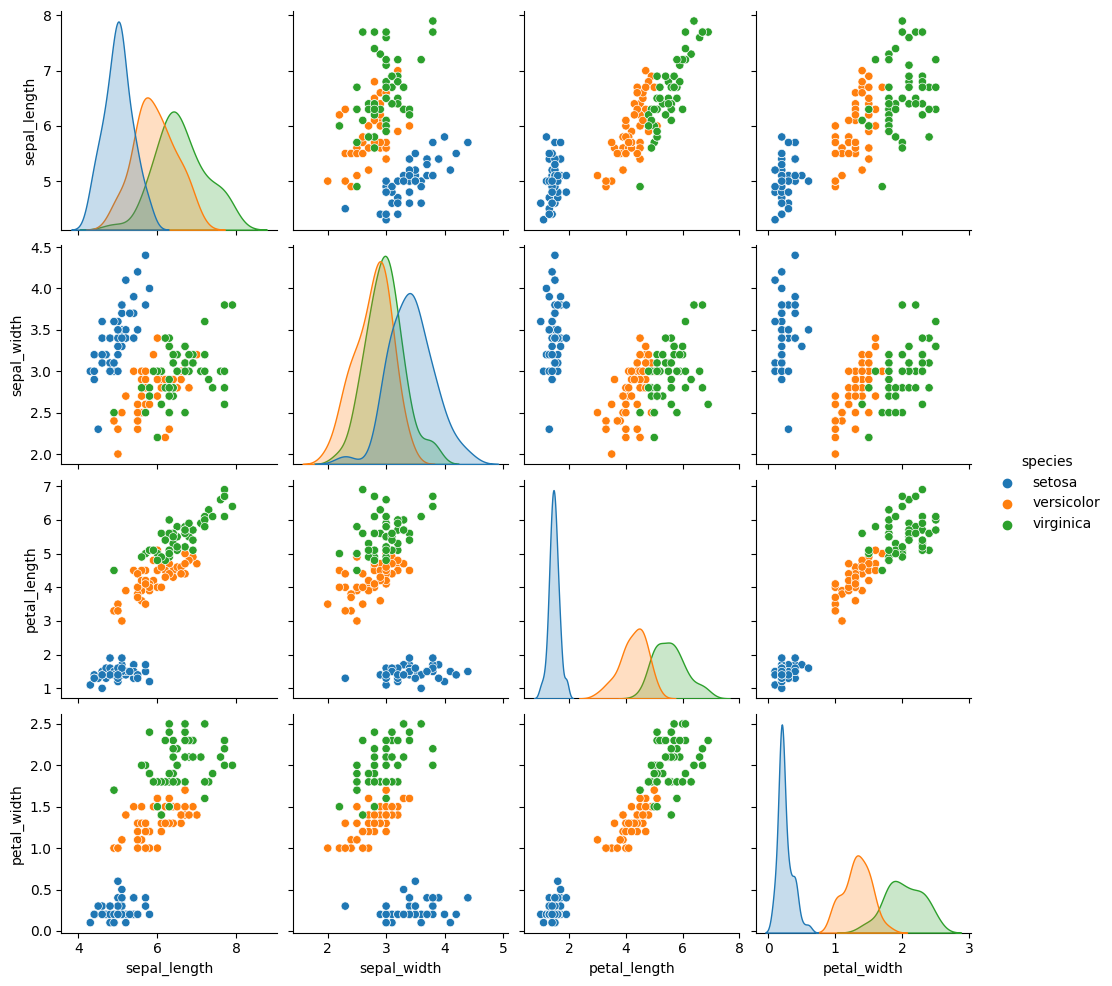

In [2]:
iris = sns.load_dataset('iris')
sns.pairplot(iris,hue='species')
plt.show()

### advisory!
It's generally not a good idea to setup our training data like this, i.e., not randomized within the data set (e.g. see 'labels'). This can introduce systemic biases in our model. In the spirit of keeping it simple for now though ...

In [3]:
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Create the ANN Model

In [4]:
ANNiris = nn.Sequential(
    nn.Linear(4,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,3)
)

# Combines Cross-entropy with torch.nn.LogSoftmax. Hence, why we can omit declaration of it in our 'ANNiris' defintion
lossfn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(ANNiris.parameters(),lr=0.01)

## Train the Model

In [5]:
Nepochs = 1000
losses = torch.zeros(Nepochs)
ongoingAcc = []

for epoch in range(Nepochs):
    # forward pass
    yHat = ANNiris(data)
    # compute loss
    loss = lossfn(yHat,labels)
    losses[epoch] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute step accuracy
    matches = torch.argmax(yHat,axis=1) == labels
    matchesNumeric = matches.float()
    accuracyPct = 100*torch.mean(matchesNumeric)
    ongoingAcc.append( accuracyPct )

# final forward pass
predictions = ANNiris(data)
predLabels = torch.argmax(predictions,axis=1)
totalAcc = 100*torch.mean(( predLabels == labels ).float())

## Visualize Results

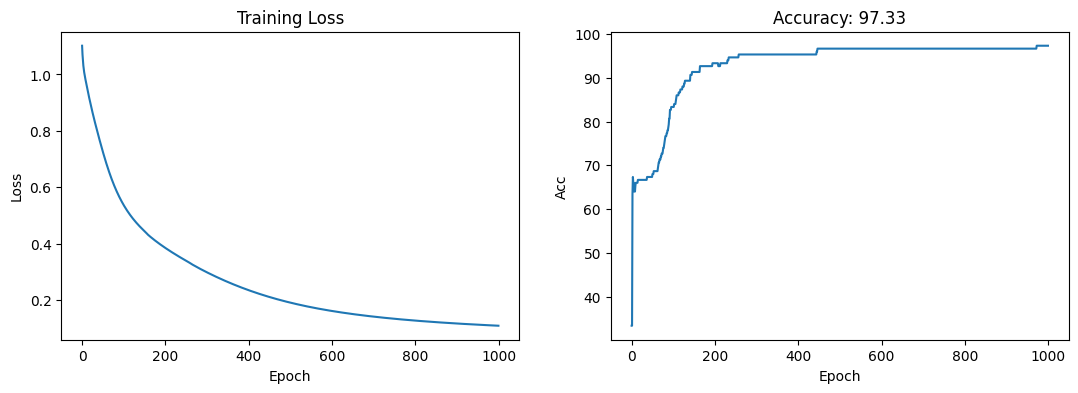

In [6]:
fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training Loss')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy: %.2f' %totalAcc)

plt.show()

### Confirm!
> Ensure that all model predictions sum to 1, but _only_ when activated by the _softmax_ function

In [7]:
sm = nn.Softmax(1)
print('without softmax!: {}'.format(torch.sum(yHat,axis=1)))
print('with softmax!: {}'.format(torch.sum(sm(yHat),axis=1)))

without softmax!: tensor([1.2074, 1.0550, 1.1083, 1.0073, 1.2074, 1.2656, 1.1055, 1.1476, 0.9575,
        1.0486, 1.2712, 1.0831, 1.0430, 1.0414, 1.4706, 1.4552, 1.3660, 1.2115,
        1.2873, 1.2399, 1.1286, 1.2264, 1.2210, 1.0804, 0.9939, 0.9994, 1.1155,
        1.2006, 1.2075, 1.0158, 1.0018, 1.2037, 1.2970, 1.3984, 1.0459, 1.1851,
        1.3037, 1.1843, 1.0200, 1.1628, 1.2184, 0.8384, 1.0535, 1.1512, 1.1499,
        1.0395, 1.2113, 1.0661, 1.2536, 1.1545, 0.3311, 0.3301, 0.3065, 0.2535,
        0.2985, 0.2665, 0.3387, 0.2802, 0.2696, 0.2910, 0.1994, 0.3219, 0.2071,
        0.2841, 0.4196, 0.3582, 0.3095, 0.2270, 0.2724, 0.2318, 0.3633, 0.3249,
        0.2782, 0.2457, 0.2988, 0.3236, 0.2777, 0.3333, 0.3050, 0.3674, 0.2287,
        0.2371, 0.2878, 0.3011, 0.3094, 0.3649, 0.3106, 0.2467, 0.2962, 0.2628,
        0.2421, 0.2908, 0.2508, 0.2659, 0.2681, 0.2743, 0.2775, 0.2793, 0.4301,
        0.2749, 0.4624, 0.3523, 0.3826, 0.3362, 0.4041, 0.3734, 0.3217, 0.3199,
        0.3158, 0.4735

## Plot the Raw Model Outputs

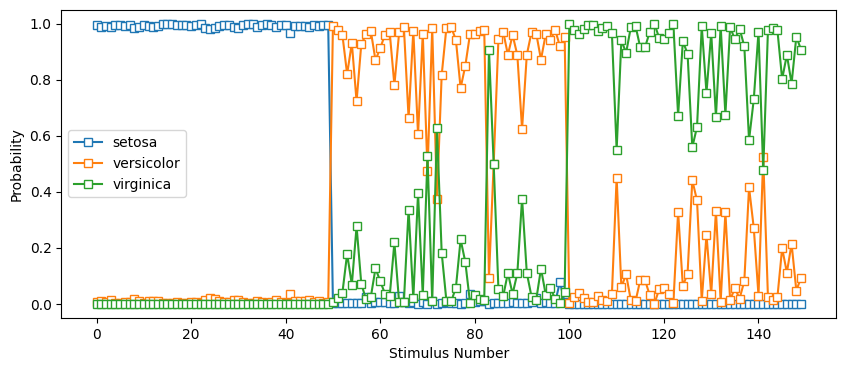

In [8]:
fig = plt.figure(figsize=(10,4))

# try it again without the softmax!
plt.plot(sm(yHat.detach()),'s-',markerfacecolor='w',label='y')
plt.xlabel('Stimulus Number')
plt.ylabel('Probability')
plt.legend(['setosa','versicolor','virginica'])
plt.show()